# Predictive Modeling for Fraud Amidst Imbalance

**After the initial data exploration and aware of the challenge posed by the severe class imbalance, we moved on to building predictive models. The objective is to develop a classifier that can identify rare fraudulent transactions with the highest possible accuracy, while minimizing false alarms.**

**To kick off our mission of building an effective fraud detector, the first step is to set up our modeling environment. This involves importing specialized libraries, defining any necessary configurations, and loading our already processed dataset.**

In [1]:
# Import essential data manipulation and plotting libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import scikit-learn components for preprocessing, metrics, and model selection
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
)

# Import various classifier models
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression # Linear model for classification

from sklearn.tree import DecisionTreeClassifier # Tree-based model
from lightgbm import LGBMClassifier # Gradient boosting model (LightGBM)
from xgboost import XGBClassifier # Gradient boosting model (XGBoost)

# Import function to plot feature importance for XGBoost
from xgboost import plot_importance


from sklearn.neighbors import KNeighborsClassifier # Instance-based learning model

# Import utilities for splitting data and evaluating feature importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# Import function for saving models
from joblib import dump

# Import custom utility functions and configuration variables from 'src' directory
from src.utils import dataframe_coefficients
from src.config import PROCESSED_DATA, FINAL_MODEL
from src.graphics import plot_compare_model_metrics, plot_coefficients
from src.models import RANDOM_STATE
from src.models import (
    classifier_grid_search_cv,
    train_and_validate_classification_model,
    organize_results,
)

# Set the visual theme for seaborn plots to "bright"
sns.set_theme(palette="bright")

# Load the processed data from a Parquet file into a pandas DataFrame
df = pd.read_parquet(PROCESSED_DATA)

**Before we fire up the modeling engines, let's do a quick final inspection of our dataset. A glance at the first few rows (.head()) and dimensions (.shape) just to confirm everything is loaded correctly and as expected after preprocessing. It's our final "safety check"!**

In [2]:
# Display the first five lines
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V23,V24,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.403993,0.251412,-0.018307,-0.110474,0.066928,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.145783,-0.069083,-0.225775,0.101288,-0.339846,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.232622,-0.208038,-0.108300,-0.190321,-1.175575,-0.221929,0.062723,0.061458,123.50,0
3,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.803487,0.408542,-0.009431,-0.137458,0.141267,0.502292,0.219422,0.215153,69.99,0
4,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.033194,0.084968,-0.208254,-0.026398,-0.371427,0.105915,0.253844,0.081080,3.67,0


In [3]:
# Display the last five lines
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V23,V24,V26,V27,V28,Amount,Class
256575,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.391167,1.252967,0.778584,0.639419,-0.294885,0.788395,0.292680,0.147968,390.00,1
256576,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.737657,0.226138,0.370612,-0.145640,-0.081049,0.739467,0.389152,0.186637,0.76,1
256577,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.266272,0.247968,0.751826,0.190944,0.032070,0.471111,0.385107,0.194361,77.89,1
256578,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,-0.035480,0.306271,0.583276,-0.456108,-0.183659,0.606116,0.884876,-0.253700,245.00,1
256579,170348.0,1.991976,0.158476,-2.583441,0.408670,1.151147,-0.096695,0.223050,-0.068384,0.577829,...,0.593509,-0.017652,-0.164350,-0.072173,-0.450261,-0.289617,0.002988,-0.015309,42.53,1


## Preparing the Clues for the Detective Model:
**With the data inspected, we begin the crucial phase of preparing the "clues" (features) that will feed our fraud detection model. Each type of information will receive tailored treatment:**

**Fundamental Split:**
- **First, we separate our field of investigation into X (features) and y (target).**

**Fine-Tuning for Time and Amount:**
- **The Time column, which marks the transaction time, will be normalized using MinMaxScaler. This will put its values on a common scale (usually between 0 and 1), which can help certain algorithms.**
- **The Amount column, known for its wide variation in values, will undergo a more robust transformation with PowerTransformer. The goal here is to make its distribution closer to normal, which can stabilize the model and improve its learning.**

**Robust Scaling for PCA Features (V1-V28):**
- **The V1 to V28 columns, which are the result of Principal Component Analysis (PCA) and thus already anonymized and transformed, still require scaling. For these, we've chosen RobustScaler. This technique is particularly useful because it is less sensitive to outliers. Given that frauds can manifest precisely as these discrepant points in the data, using RobustScaler is an important precaution to prevent these outliers from excessively distorting the scale of our PCA features.**

**This meticulous preparation ensures that each feature contributes as effectively as possible to our model, optimizing its chances of unveiling the traces of fraud.**

In [4]:
# Define a list of columns to be scaled using MinMaxScaler
columns_min_max = ["Time"]

# Define a list of columns to be transformed using PowerTransformer
columns_power_transformer = ["Amount"]

# Define the target variable column
target = ["Class"]

# Identify columns for RobustScaler: all columns not already assigned for other transformations or as the target
columns_robust_scaler = [
    column for column in df.columns if column not in (
        columns_min_max + columns_power_transformer + target
    )
]

# Display the list of columns designated for RobustScaler
columns_robust_scaler

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V23',
 'V24',
 'V26',
 'V27',
 'V28']

In [5]:
# Create the feature matrix 'X' by dropping the target columns from the DataFrame 
X = df.drop(columns=target)

# Create the target vector 'y'
y = df[target].values.ravel()

In [6]:
# Define a ColumnTransformer to apply different preprocessing techniques to specific columns
preprocessing = ColumnTransformer(
    transformers=[
        ("min_max", MinMaxScaler(), columns_min_max),
        ("robust", RobustScaler(), columns_robust_scaler),
        ("power_transform", PowerTransformer(), columns_power_transformer),
    ]
)

In [7]:
# Calculate the ratio of negative class samples to positive class samples
scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]

# Display the calculated scale_pos_weight value
scale_pos_weight

np.float64(520.5040650406504)

## Defining Classifiers and the Challenge Arena
**With our data transformed and ready, it was time to summon a team of "expert detectives" – our classification algorithms – to see which could unravel the traces of fraud most masterfully.**

**Our selection of candidates was diverse, covering different investigative tactics:**

- **The Starting Point (DummyClassifier): We began with a DummyClassifier (using the stratified strategy). It would give us a baseline; any serious model would need to outperform it.**

- **The Classic Detectives (LogisticRegression, DecisionTreeClassifier): Next, we brought Logistic Regression and Decision Tree into the field. For both, we set class_weight="balanced" hoping to mitigate the strong imbalance between fraudulent and genuine transactions.**

- **The Special Forces (Ensembles: LGBMClassifier, XGBClassifier): For greater firepower, we deployed the ensemble models LGBMClassifier and XGBClassifier. In these, we used the scale_pos_weight parameter (calculated at approximately 520.5, reflecting the ratio between negative and positive classes) to instruct them to severely penalize errors in classifying the rare, yet crucial, fraudulent transactions.**

- **The Proximity Specialist (KNeighborsClassifier): The KNeighborsClassifier was also included to test an approach based on neighbor similarity.**

**Ensuring Fair and Accurate Evaluation:**

**To ensure the competition was fair and our results reliable, we used StratifiedKFold cross-validation with 5 folds. This technique ensures that the original proportion of frauds and non-frauds is maintained in each of the 5 testing "rounds" – essential in our imbalanced data scenario.**

**As success metrics, we chose Average Precision and the Area Under the ROC Curve (ROC AUC). Both are more suitable for evaluating performance on imbalanced classes than traditional accuracy, which could give us a false sense of security.**

**In the end, the results from all "detectives" were consolidated, allowing for a clear comparative analysis. The model that demonstrated the best nose for fraud was duly saved as our FINAL_MODEL, ready to be deployed when needed.**

In [8]:
# Define a dictionary 'classifiers' to store configurations for various models
classifiers = {
    "DummyClassifier": {
        "preprocessor": None,
        "classifier": DummyClassifier(strategy="stratified"),
    },
    "LogisticRegression": {
        "preprocessor": preprocessing,
        "classifier": LogisticRegression(class_weight="balanced"),
    },
    "DecisionTreeClassifier": {
        "preprocessor": None,      
        "classifier": DecisionTreeClassifier(class_weight="balanced"),
    },
    "LGBMClassifier": {
        "preprocessor": None,
        "classifier": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            scale_pos_weight=scale_pos_weight,
        ),
    },
    "XGBClassifier": {
        "preprocessor": None,
        "classifier": XGBClassifier(
            random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight
        ),
    },
    "KNeighborsClassifier": {
        "preprocessor": preprocessing,
        "classifier": KNeighborsClassifier(),
    },
}

In [9]:
# Initialize StratifiedKFold for 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [10]:
# Train and validate each classifier defined in the 'classifiers' dictionary
results = {
    model_name: train_and_validate_classification_model(X, y, kf, **classifier)
    for model_name, classifier in classifiers.items()
}

# Organize the raw 'results' from model training and validation into a pandas DataFrame
df_results = organize_results(results)

# Display the DataFrame containing the organized performance metrics for each model
df_results

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.021101,0.013873,0.995947,0.498926,0.0,0.0,0.0,0.498955,0.00191,0.034974
1,DummyClassifier,0.02003,0.012516,0.996395,0.499151,0.0,0.0,0.0,0.509277,0.002292,0.032545
2,DummyClassifier,0.020019,0.011516,0.996122,0.509199,0.019704,0.019048,0.020408,0.499121,0.00191,0.031536
3,DummyClassifier,0.020029,0.011517,0.996161,0.499043,0.0,0.0,0.0,0.498955,0.001929,0.031546
4,DummyClassifier,0.019518,0.011022,0.996103,0.499014,0.0,0.0,0.0,0.498858,0.001929,0.030539
5,LogisticRegression,0.906089,0.045034,0.98328,0.935609,0.168605,0.093148,0.887755,0.985234,0.608503,0.951123
6,LogisticRegression,0.823499,0.060143,0.977785,0.958317,0.138973,0.075041,0.938776,0.987455,0.731336,0.883642
7,LogisticRegression,0.780119,0.045483,0.978545,0.958698,0.143191,0.077506,0.938776,0.978128,0.800227,0.825602
8,LogisticRegression,0.684582,0.042708,0.981292,0.940221,0.156415,0.085659,0.89899,0.97971,0.687418,0.72729
9,LogisticRegression,0.577784,0.039697,0.978252,0.95382,0.141538,0.076603,0.929293,0.981516,0.738762,0.617481


In [11]:
# Group results by model, calculate the mean of metrics for each
df_results.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.020139,0.012089,0.996145,0.501067,0.003941,0.00381,0.004082,0.501033,0.001994,0.032228
LGBMClassifier,0.430824,0.03946,0.929114,0.888383,0.059261,0.031073,0.847495,0.883652,0.027255,0.470284
DecisionTreeClassifier,5.020249,0.016964,0.999182,0.881923,0.781798,0.800369,0.764214,0.881923,0.612517,5.037213
LogisticRegression,0.754415,0.046613,0.979831,0.949333,0.149744,0.081591,0.918718,0.982408,0.713249,0.801028
KNeighborsClassifier,0.380713,7.705301,0.999462,0.882054,0.844453,0.945503,0.764193,0.928754,0.818819,8.086014
XGBClassifier,0.498748,0.053268,0.999622,0.923736,0.895317,0.949773,0.847557,0.986293,0.889975,0.552016


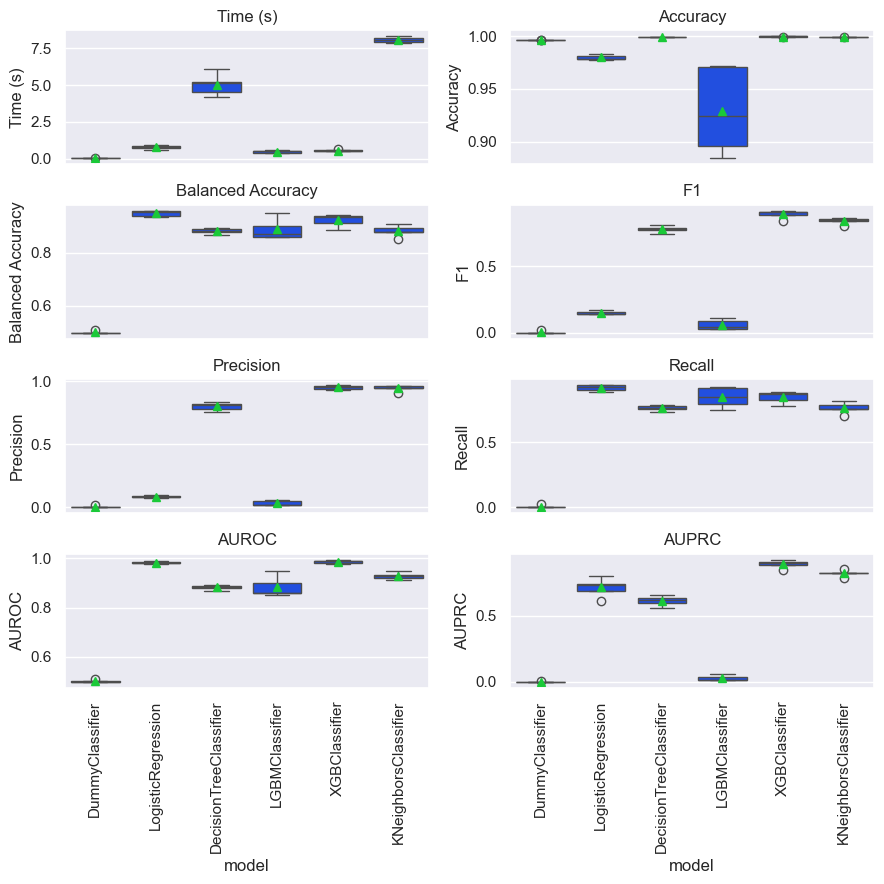

In [12]:
# Call a custom function 'plot_compare_model_metrics' to visualize and compare
plot_compare_model_metrics(df_results)

**After the rigorous evaluation of all our "detectives," one of them shone the brightest! The XGBClassifier proved to be the most insightful, managing to excel in fraud detection and achieving performance metrics that were very satisfactory, especially considering the complexity and imbalance of our data. It is, without a doubt, our top candidate!**

## Unveiling the Champion Classifier:

**With XGBClassifier chosen as our best model, we won't just accept its performance; we want to understand how it unveils the traces of fraud. Our next mission is:**

- **Analyze Feature Importance: We will investigate which characteristics (features) the XGBClassifier considered most relevant and decisive when making its predictions.**

- **Refinement (Removing Less Useful Features): Based on this analysis, we will identify features that had little or no impact on the model's decisions. Removing these "secondary clues" can simplify the model, make it faster, and sometimes even improve its generalization ability by focusing only on what truly matters.**

**This "interrogation" stage of the model will give us valuable insights and may lead to an even more efficient detective!**

In [13]:
# Access the configuration for the "XGBClassifier" from the 'classifiers' dictionary
classifiers["XGBClassifier"]

{'preprocessor': None,
 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=-1, num_parallel_tree=None, ...)}

In [14]:
train_and_validate_classification_model(
    X, y, kf, **classifiers["XGBClassifier"]
)

{'fit_time': array([0.48978782, 0.44077277, 0.4646709 , 0.47199678, 0.48560858]),
 'score_time': array([0.04854679, 0.04954839, 0.04905224, 0.05355167, 0.05004883]),
 'test_accuracy': array([0.99945436, 0.99966872, 0.99970769, 0.99961026, 0.99966872]),
 'test_balanced_accuracy': array([0.88769653, 0.94381898, 0.93874622, 0.91411213, 0.93430438]),
 'test_f1': array([0.84444444, 0.91099476, 0.9197861 , 0.89130435, 0.91005291]),
 'test_precision': array([0.92682927, 0.93548387, 0.96629213, 0.96470588, 0.95555556]),
 'test_recall': array([0.7755102 , 0.8877551 , 0.87755102, 0.82828283, 0.86868687]),
 'test_roc_auc': array([0.97754795, 0.99096101, 0.98851886, 0.97993978, 0.99449895]),
 'test_average_precision': array([0.84433049, 0.90305055, 0.89986844, 0.88100103, 0.92162321])}

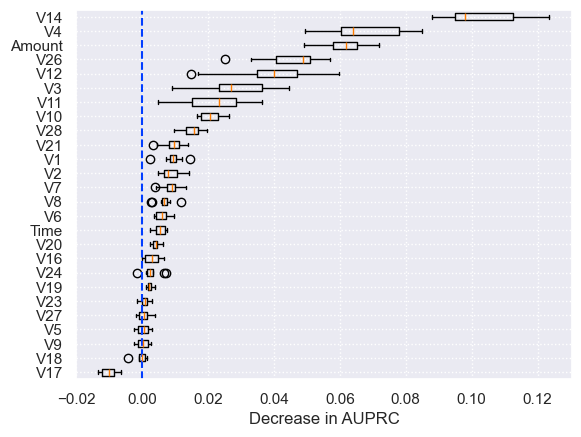

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, stratify=y
)

clf = classifiers["XGBClassifier"]["classifier"]

clf.fit(X_train, y_train)

perm_imp = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="average_precision",
)

fig, ax = plt.subplots()

ordem = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[ordem].T, vert=False, tick_labels=X.columns[ordem])
ax.axvline(x=0, linestyle="--")
ax.set_xlabel("Decrease in AUPRC")
ax.grid(True, linestyle=":")

plt.show()

In [16]:
perm_imp.importances_mean

array([ 0.00527042,  0.00928424,  0.00870414,  0.02871306,  0.06841606,
        0.00044666,  0.00616417,  0.00869138,  0.00665531,  0.00021158,
        0.0207063 ,  0.02268825,  0.03889337,  0.10351298,  0.00300705,
       -0.01019586, -0.00024938,  0.00235822,  0.00421469,  0.00933825,
        0.00068464,  0.00278895,  0.04534865,  0.0005824 ,  0.01521219,
        0.06118491])

In [17]:
X.columns[perm_imp.importances_mean < 0.01]

Index(['Time', 'V1', 'V2', 'V5', 'V6', 'V7', 'V8', 'V9', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V23', 'V24', 'V27'],
      dtype='object')

In [18]:
X = X.drop(columns=X.columns[perm_imp.importances_mean < 0.01])

X.columns

Index(['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V26', 'V28', 'Amount'], dtype='object')

In [19]:
train_and_validate_classification_model(
    X, y, kf, **classifiers["XGBClassifier"]
)

{'fit_time': array([0.28933454, 0.23852873, 0.24301434, 0.23903394, 0.23692155]),
 'score_time': array([0.1362226 , 0.05554986, 0.04554653, 0.04854798, 0.04303837]),
 'test_accuracy': array([0.99941539, 0.99962975, 0.99951282, 0.99953231, 0.99949334]),
 'test_balanced_accuracy': array([0.88258473, 0.93870717, 0.91827949, 0.91911382, 0.92413504]),
 'test_f1': array([0.83333333, 0.90052356, 0.86772487, 0.87368421, 0.86597938]),
 'test_precision': array([0.91463415, 0.92473118, 0.9010989 , 0.91208791, 0.88421053]),
 'test_recall': array([0.76530612, 0.87755102, 0.83673469, 0.83838384, 0.84848485]),
 'test_roc_auc': array([0.97385246, 0.97489323, 0.98426693, 0.97711579, 0.9926295 ]),
 'test_average_precision': array([0.82628555, 0.88727911, 0.88560336, 0.87943563, 0.88295909])}

**After "talking" with our XGBClassifier and understanding which clues it values most, we've made significant progress! We identified a lean set of nine features as the most important for its decisions.**

**This is a major optimization compared to the twenty six features we were previously using. With a smaller number of "investigative tools," our model becomes:**

- **Faster: Less data to process means quicker predictions.**
- **Simpler and More Interpretable: It's easier to understand the logic of a model based on fewer variables, making its "conclusions" more transparent.**

**This careful selection allows us to have a more efficient detective, focused on what truly matters for identifying fraud!**

In [20]:
param_grid = {
    "clf__max_depth": [3, 6, 10],  
    # "clf__min_child_weight": [1, 3, 5],  
    "clf__gamma": [0, 0.1, 0.3],  
    "clf__subsample": [0.6, 0.8, 1.0],  
    # "clf__colsample_bytree": [0.6, 0.8, 1.0],  
    "clf__learning_rate": [0.1, 0.3, 0.5],  
    "clf__n_estimators": [10, 50, 100],  
    # "clf__reg_lambda": [1, 2, 5],  
    "clf__reg_alpha": [0, 0.5, 1],  
}

In [21]:
clf = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, scale_pos_weight=scale_pos_weight)

grid_search = classifier_grid_search_cv(
    clf, param_grid, kf, None, refit_metric="average_precision"
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=Non...
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__gamma': [0, 0.1, 0.3],
                         'clf__learning_rate': [0.1, 0.3, 0.5],
                         'clf__max_depth': [3, 6, 10],
                         'clf__n_estimators': [10, 50, 100],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [22]:
grid_search.fit(X, y)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=Non...
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__gamma': [0, 0.1, 0.3],
                         'clf__learning_rate': [0.1, 0.3, 0.5],
                         'clf__max_depth': [3, 6, 10],
                         'clf__n_estimators': [10, 50, 100],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [23]:
grid_search.best_params_

{'clf__gamma': 0,
 'clf__learning_rate': 0.3,
 'clf__max_depth': 10,
 'clf__n_estimators': 100,
 'clf__reg_alpha': 0,
 'clf__subsample': 0.8}

In [24]:
grid_search.best_score_

np.float64(0.8750183954218957)

In [25]:
grid_search.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [26]:
columns_test = [column for column in df_results.columns if column.startswith("test")]
columns_test_mean = ["mean_" + coluna for coluna in columns_test]
columns_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [27]:
for column in columns_test_mean:
    print(f"{column}: {grid_search.cv_results_[column][grid_search.best_index_]}")

mean_test_accuracy: 0.9995245147712213
mean_test_balanced_accuracy: 0.9115169043483646
mean_test_f1: 0.8686417462228473
mean_test_precision: 0.9200389584265558
mean_test_recall: 0.8231704803133374
mean_test_roc_auc: 0.9829944069108928
mean_test_average_precision: 0.8750183954218957


**After the feature selection and reduction process, our XGBClassifier didn't show an increase in performance metrics, but it maintained its previous solid performance. And herein lies an important gain: even without a jump in accuracy numbers, the model is now significantly simpler and easier to explain.**

**Achieving the same effectiveness with fewer variables is a considerable improvement! A leaner model is faster, lighter, and, crucially, its decisions become more transparent and understandable. In many scenarios, this enhanced interpretability is as valuable as a small percentage gain in a metric, especially when it comes to explaining the "clues" that lead to fraud detection.**

## Analyzing the Best Clue: A Detailed View of Feature Importance

**Before we consider our case closed, let's perform one last thorough examination of our XGBClassifier's "investigative tools." We want to understand, as clearly as possible, which clues (features) were most decisive for it in detecting fraud. To do this, we'll analyze the importance of each feature from two different perspectives, often provided by models like XGBoost:**

- **By "Weight" (Frequency): This metric will tell us how many times each feature was actually used to make a split (a decision) across all the trees that make up the model. Features with high 'weight' were frequently consulted by the model.**

-  **By "Gain": This metric is even more informative. It quantifies how much, on average, each feature contributed to reducing the model's error or improving node purity whenever it was used in a split. High 'gain' means the feature was crucial for improving prediction performance.**

**This dual analysis will allow us to confirm which are the true "super-features" in our fight against fraud, offering final insights into the most impactful factors.**

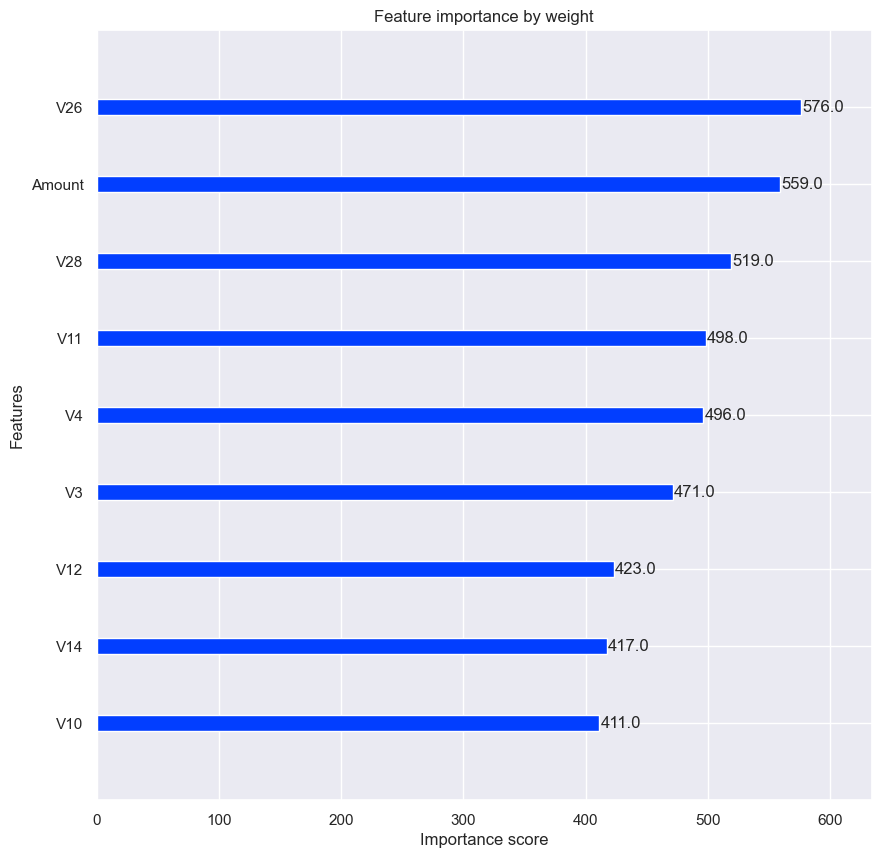

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="weight",
    title="Feature importance by weight"
)

plt.show()

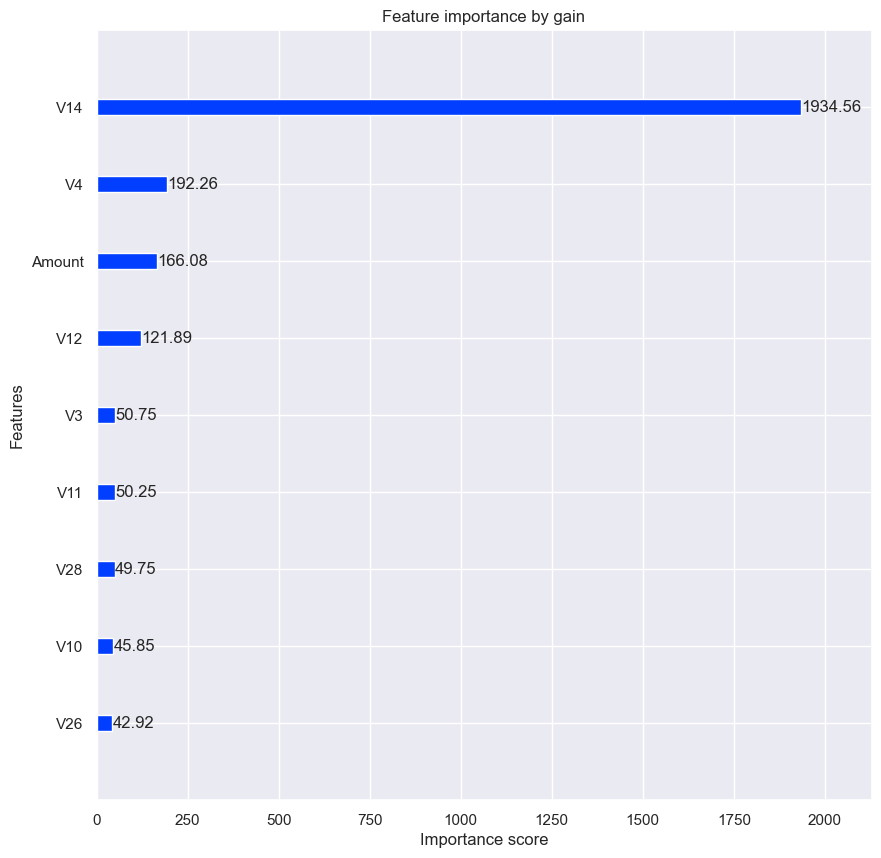

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="gain",
    title="Feature importance by gain",
    values_format="{v:.2f}"
)

plt.show()

**Our final analysis, investigating the feature importance of the XGBClassifier by "weight" (frequency of use) and "gain" (information gain/error reduction), revealed a very interesting scenario:**

- **Divergent Top Features: The first finding is that the variables considered most important by the "weight" metric are not exactly the same as those that stand out by the "gain" metric. This tells us that some features might be used many times to make splits in the trees (high "weight"), but others, even if used less frequently, might be responsible for a greater "cleanup" or information gain when they are used (high "gain").**

**"Weight" Distribution vs. Prominence in "Gain":**
- **From the "weight" perspective, we noticed that several features had a "similar" usage count, indicating that the model consulted a group of variables with relatively similar frequency.**
- **However, when looking at "gain," the story changes: the V14 feature stood out dramatically compared to all others. This suggests that while several features are utilized, V14 is exceptionally powerful in improving the model's performance and reducing error in fraud predictions. It is, by far, the "clue" that contributes most to accuracy when triggered.**

**This discovery is crucial! It shows us that while many features help the model in its overall structure, V14 appears to be the "master key" for effectively distinguishing fraudulent transactions from genuine ones in terms of real impact on performance.**

## Exporting the Model: Our "Digital Detective" Archived

**With all our investigation, modeling, and feature importance analysis work completed, the time has come to export our trained XGBClassifier. This allows us to "bottle up" the intelligence we've developed so it can be reused in future analyses or implemented in fraud detection systems.**

**An Important Consideration (The PCA Enigma):**

**It's crucial to highlight a point about the nature of our data. The V1 to V28 features, which our model uses, are the result of Principal Component Analysis (PCA) applied to the original data for anonymization. This means we do not know the real meaning or origin of each of these "V" columns.**

**This characteristic has a direct implication: for this model to be effectively used with new data in the future, that new data must undergo the exact same PCA transformation that was applied to the original dataset. Without this identical preprocessing step, or without the "map" of the original PCA transformation, the model will not be able to correctly interpret new information. This presents a challenge for the model's usability by third parties or in environments where this specific PCA transformation is not available or known, as the "clues" our model learned to recognize only exist after this specific transformation.**

In [30]:
dump(grid_search.best_estimator_, FINAL_MODEL)

['C:\\Users\\manoe\\Área de Trabalho\\IDES\\Estudos\\Hashtag\\Ciencia de Dados\\Projetos\\23. Identificação de fraudes\\models\\xgb_classifier.joblib']